### Low-Rank Matrix Recovery using Primal-Dual algorithms 
Given a video, we try and extract foreground (sparse) and background (low-rank) matrices from the frames.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import time
from scipy.sparse.linalg import svds

In [152]:
# Load the data
cap = cv2.VideoCapture("highway.avi")
init_frame = 0 
# cap.set(cv2.CAP_PROP_POS_FRAMES, init_frame)

num_frames = 60
frames = []
num_channels = 3
frame_num = 0
count = 0

for i in range(num_frames):
    ret, frame = cap.read()
    count += 10 # i.e. at 30 fps, this advances one second
    cap.set(cv2.CAP_PROP_POS_FRAMES, count)
    if not ret:
        print("Read", frame_num, "frames")
        break
    frame_num += 1
    frames.append(frame)

cap.release()
num_frames = frame_num

In [153]:
# Initialize variables
n, m, _ = frames[0].shape
 
# Flatten the frame
max_val = np.max(np.abs(frames)) 
D = np.zeros((n*m*num_channels, num_frames))
 
for i in range(num_frames):
    D[:, i] = frames[i].flatten() 
D = D/max_val  

# Add noise
np.random.seed(0)
noise_level = 0.0
D = D + noise_level*np.random.randn(D.shape[0], D.shape[1])

# Sanity check
print(D.shape)
print(np.max(D))


(230400, 60)
1.0


### Algorithm: Principal Component Pursuit by Augmented Lagrange Multiplier for Stable PCA
PCP corresponds to the primal formulation stated in SPCA!
The paper claims that Augmented Lagrange Multiplier converges in fewer iterations as compared to Accelerated Proximal Gradient with better accuracy. Hence, we have chosen to implement this algorithm for PCP. 

In [92]:
U, S, V = np.linalg.svd(D, full_matrices=False)
print(np.dot(U, S))

[-1.15392075 -1.49394287 -1.30435046 ... -1.67168762 -1.95700722
 -2.16911472]


In [4]:

def algorithm_run(D, lamda, mu, error_tol = 1e-8, max_iter = 100, print_every = 10):
    L = np.zeros(D.shape) 
    S = np.zeros(D.shape) 
    Y = np.zeros(D.shape) 

    iter = 0    
    error = np.inf
    mu_inv = 1/mu

    # Solve for L and S
    while error > error_tol and iter < max_iter:
        # L update
        U, s, V = np.linalg.svd(D - S + mu_inv*Y, full_matrices=False)
        # Threshold singular values
        s = np.sign(s)*np.maximum(np.abs(s) - mu, 0)
        L = np.dot(U, np.dot(np.diag(s), V))

        # S update
        M = D - L + mu_inv*Y
        S = np.sign(M)*np.maximum(np.abs(M) - mu*lamda, 0)

        # Y update
        Y = Y + mu*(D - L - S)

        # Error
        error = np.linalg.norm(D - L - S, 'fro')/np.linalg.norm(D, 'fro')
        cvx_error = np.linalg.norm(L, 'nuc') + lamda*np.linalg.norm(S.flatten(), 1)
        iter += 1  
        if iter % print_every == 0:
            print(f"Iteration {iter}, error = {cvx_error}", \
                  f"L rank = {np.linalg.matrix_rank(L)}, S l1 = {np.linalg.norm(S.flatten(), 1)}")
    
    return L, S, cvx_error

In [74]:

# Cross-validation ranges for hyper-parameters
lambdas = np.logspace(-3, 3, 7)
mus = np.logspace(-3, 1, 4) # [m*n/(4*np.linalg.norm(D, 1))]

# Hyper-parameter tuning
best_error = np.inf
best_lambda = 0
best_mu = 0
for lamda in lambdas:
    for mu in mus:
        # Measure the time to run the algorithm 
        t = time.time()  
        L, S, error = algorithm_run(D, lamda, mu, max_iter = 10)
        print(f"Time to run the algorithm = {time.time() - t}", f"Error = {error}",\
               f"L rank = {np.linalg.matrix_rank(L)}", f"S L1 = {np.linalg.norm(S.flatten(), 1)}") 
        if error < best_error:
            best_error = error
            best_lambda = lamda
            best_mu = mu

print(f"Best error = {best_error}, lambda = {best_lambda}, mu = {best_mu}")


Time to run the algorithm = 0.8215842247009277 Error = 1482.5523338617045 L rank = 30 S L1 = 5.53788049457788
Iteration 10, error = 1478.0075124249097 L rank = 30, S l1 = 603.0555109741679
Time to run the algorithm = 4.131013870239258 Error = 1478.0075124249097 L rank = 30 S L1 = 603.0555109741679
Iteration 10, error = 1407.084521402342 L rank = 13, S l1 = 14649.359199904395
Time to run the algorithm = 3.8429620265960693 Error = 1407.084521402342 L rank = 13 S L1 = 14649.359199904395
Iteration 10, error = 1285.43656714189 L rank = 1, S l1 = 56502.93253664829
Time to run the algorithm = 3.8039169311523438 Error = 1285.43656714189 L rank = 1 S L1 = 56502.93253664829
Time to run the algorithm = 0.7688229084014893 Error = 1482.5839637094691 L rank = 30 S L1 = 0.6914240666763277
Iteration 10, error = 1481.4258398605293 L rank = 30, S l1 = 73.87407106377445
Time to run the algorithm = 3.752897024154663 Error = 1481.4258398605293 L rank = 30 S L1 = 73.87407106377445


KeyboardInterrupt: 

In [154]:
best_lambda = 0.001
best_mu = 10

In [155]:
# Run the algorithm with the best hyper-parameters
print("Running the algorithm with the best hyper-parameters", best_lambda, best_mu)
L, S, error = algorithm_run(D, best_lambda, best_mu, error_tol = 1e-7, max_iter = 20, print_every = 1) 
print(f"Error = {error}", f"L rank = {np.linalg.matrix_rank(L)}", f"S L1 = {np.linalg.norm(S.flatten(), 1)}")

Running the algorithm with the best hyper-parameters 0.001 10
Iteration 1, error = 3132.842090207189 L rank = 55, S l1 = 57035.27218685919
Iteration 2, error = 2901.1625333546617 L rank = 48, S l1 = 121665.44771662127
Iteration 3, error = 2636.7894965665664 L rank = 42, S l1 = 182910.3252830764
Iteration 4, error = 2437.583314101129 L rank = 30, S l1 = 237177.35718048265
Iteration 5, error = 2302.079304583918 L rank = 23, S l1 = 278910.48861602833
Iteration 6, error = 2212.908631362501 L rank = 16, S l1 = 308964.519053875
Iteration 7, error = 2154.3046161056586 L rank = 12, S l1 = 330704.3918376454
Iteration 8, error = 2118.1914604963517 L rank = 8, S l1 = 345685.2954739936
Iteration 9, error = 2098.3608988290352 L rank = 6, S l1 = 355375.8621845455
Iteration 10, error = 2090.014884170331 L rank = 4, S l1 = 360611.5015626853
Iteration 11, error = 2086.589197272179 L rank = 2, S l1 = 363382.17023970006
Iteration 12, error = 2086.6681816451382 L rank = 2, S l1 = 363303.78562432784
Iterat

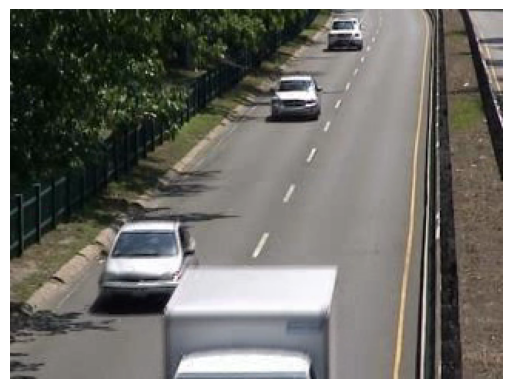

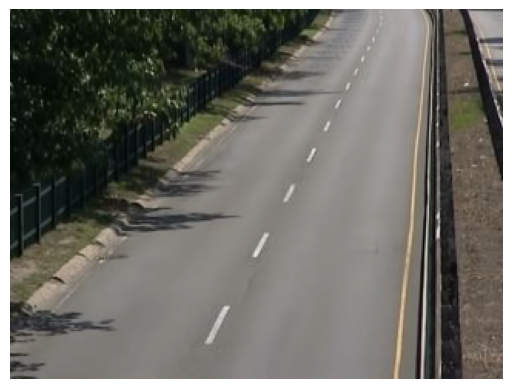

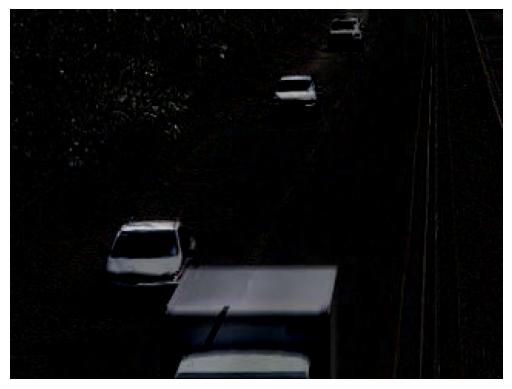

In [156]:
# Reshape the low-rank and sparse components 
L_frame = L.reshape(n, m, num_channels, num_frames)*max_val 
S_frame = S.reshape(n, m, num_channels, num_frames)*max_val 

# Clip the results
L_frame = np.clip(L_frame, 0, 255)
S_frame = np.clip(S_frame, 0, 255)


# Show the results by playing videos side by side using cv2
i = 29
plt.imshow(frames[i][ :, :, ::-1].astype(np.uint8))
# remove the axis
plt.axis('off')
plt.show()
plt.imshow(L_frame[ :, :, ::-1, i].astype(np.uint8))
plt.axis('off')
plt.show()
plt.imshow(S_frame[ :, :, ::-1, i].astype(np.uint8))
plt.axis('off')
plt.show()

### Algorithm: Dual Optimization


In [ ]:
k = svds(D, k = 1, return_singular_vectors = True)
print(k[1])
print(k[0].shape, k[1].shape, k[2].shape)

[1235.38834431]
(230400, 1) (1,) (1, 30)


In [117]:
def maximize_dual(D, lamda, error_tol = 1e-8, max_iter = 100, print_every = 10):
    L = np.zeros(D.shape) 
    S = np.zeros(D.shape) 
    L_error = np.inf
    S_error = np.inf
    error = np.inf
    L_prev = np.inf*np.ones(D.shape)
    S_prev = np.inf*np.ones(D.shape)


    lamda_inv = 1/lamda
    error_tol = 1e-8*np.linalg.norm(D, 'fro')
    ascent_error_tol = 2e-5*np.linalg.norm(D, 'fro')

    def J(Y):
        max_s = svds(Y, k = 1, return_singular_vectors = False)
        return np.max([max_s[0], lamda_inv*np.linalg.norm(Y.flatten(), np.inf)])
    
    def pi_2(U, Vt, M):
        D_bar = np.dot(U.T, np.dot(M, Vt.T))
        D_ = 0.5*(D_bar + D_bar.T)
        D_u, D_s, D_v = np.linalg.svd(D_)
        X = np.dot(D_u, np.dot(np.max(D_s, 0), D_v))
        return np.dot(U, np.dot(X, Vt))
    
    def pi_inf(Y):
        inf = np.linalg.norm(Y.flatten(), np.inf)
        indices = np.where(np.abs(Y)/inf > 0.95)
        M = np.zeros(D.shape)
        M[indices] = np.abs(Y[indices]) 
        M = np.sign(Y)*M
        return M
    
    iter = 0
    init = np.sign(D).astype(np.float64)
    Y = init/J(init)
    while error > ascent_error_tol and iter < max_iter:
        # Compute the project Dk of D onto N(Y)
        U, L2_norm, Vt = svds(Y, k = 1, return_singular_vectors = True)
        L2_norm = L2_norm[0]
        Linf_norm = lamda_inv*np.linalg.norm(Y.flatten(), np.inf)
        L_prev = L
        S_prev = S
        Y_prev = Y 

        if abs(L2_norm - Linf_norm) < 1e-1:
            print("L2 norm and Linf norm are close")
            L = np.zeros(D.shape)
            S = np.zeros(D.shape)

            # Perform Alternating minimization
            inner_iter = 0
            while (L_error > error_tol or S_error > error_tol) and inner_iter < max_iter:
                L = pi_2(U, Vt, D - S)
                S = pi_inf(D - L)

                inner_iter += 1
                L_error = np.linalg.norm(L - L_prev, 'fro')
                S_error = np.linalg.norm(S - S_prev, 'fro')
                L_prev = L
                S_prev = S

            Dk = L + S

        elif L2_norm > Linf_norm:
            print("L2 norm is greater than Linf norm")
            Dk = pi_2(U, Vt, D)
            L = D
            S = np.zeros(D.shape)
        else:
            print("Linf norm is greater than L2 norm")
            Dk = pi_inf(D)
            L = np.zeros(D.shape)
            S = D
        
        # Line Search 
        delta = np.ones(D.shape)
        flag = True
        line_iter = 0
        while flag and line_iter < 10:
            Z1 = (Y + delta*(D - Dk))/J(Y + delta*(D - Dk))
            Z2 = Y/J(Y)
            indices = np.where(Z1 - Z2 + delta*np.linalg.norm(D - Dk, "fro") >= 0)
            if len(indices) == 0:
                flag = False
            else:
                delta[indices] = delta[indices]*0.5
            line_iter += 1
            
        Y = (Y + delta*(D - Dk))/J(Y + delta*(D - Dk))

        # Error
        error = np.linalg.norm(D - Dk, 'fro')
        L_error = np.linalg.norm(L - L_prev, 'fro')
        S_error = np.linalg.norm(S - S_prev, 'fro')
        print("Y_error", np.linalg.norm(Y - Y_prev, 'fro'))
        
        iter += 1  
        if iter % print_every == 0:
            print(L2_norm, Linf_norm)
            print(f"Iteration {iter}, L error = {L_error}", f"S error = {S_error}", f"error = {error}")
    
    return L, S, error

In [114]:
best_lambda = 0.001

In [161]:
L, S, error = maximize_dual(D, best_lambda, error_tol = 1e-7, max_iter = 20, print_every = 1)

L2 norm is greater than Linf norm
Y_error 0.6713339707217407
1.0 0.26929296236056216
Iteration 1, L error = 1737.026302845718 S error = 0.0 error = 819.9669840169466
L2 norm is greater than Linf norm
Y_error 0.4813597602705637
0.9999999999999996 0.8461973794831144
Iteration 2, L error = 0.0 S error = 0.0 error = 420.7926733704982
Linf norm is greater than L2 norm
Y_error 0.4533109727936288
0.5743656608357439 1.0
Iteration 3, L error = 1737.026302845718 S error = 1737.026302845718 error = 1710.9429421776892
L2 norm is greater than Linf norm
Y_error 0.40964642115843725
1.0 0.8255376995450737
Iteration 4, L error = 1737.026302845718 S error = 1737.026302845718 error = 301.07917947914973
Linf norm is greater than L2 norm
Y_error 0.41124763517679375
0.6083670262391464 1.0
Iteration 5, L error = 1737.026302845718 S error = 1737.026302845718 error = 1710.9429421776892
L2 norm is greater than Linf norm
Y_error 0.4278069925486497
0.9999999999999999 0.8555627376693657
Iteration 6, L error = 1737

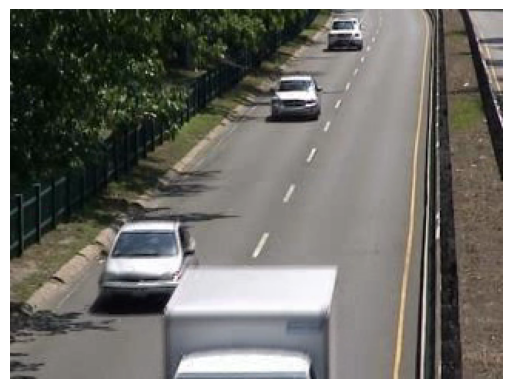

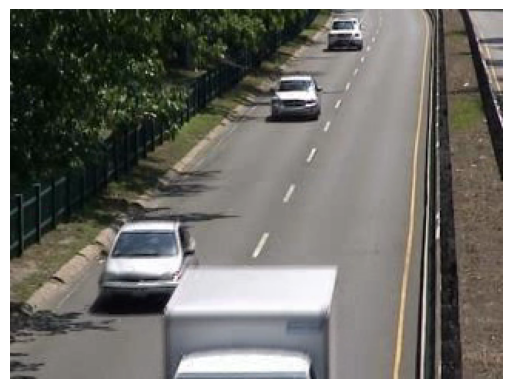

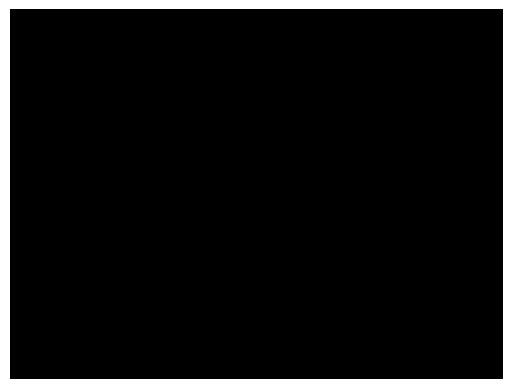

In [160]:
# Reshape the low-rank and sparse components 
L_frame = L.reshape(n, m, num_channels, num_frames)*max_val 
# S_frame = S.reshape(n, m, num_channels, num_frames)*max_val 
S_frame = (D - L).reshape(n, m, num_channels, num_frames)*max_val

# Clip the results
L_frame = np.clip(L_frame, 0, 255)
S_frame = np.clip(S_frame, 0, 255)


# Show the results by playing videos side by side using cv2
i = 29
plt.imshow(frames[i][ :, :, ::-1].astype(np.uint8))
# remove the axis
plt.axis('off')
plt.show()
plt.imshow(L_frame[ :, :, ::-1, i].astype(np.uint8))
plt.axis('off')
plt.show()
plt.imshow(S_frame[ :, :, ::-1, i].astype(np.uint8))
plt.axis('off')
plt.show()

(240, 320, 3)


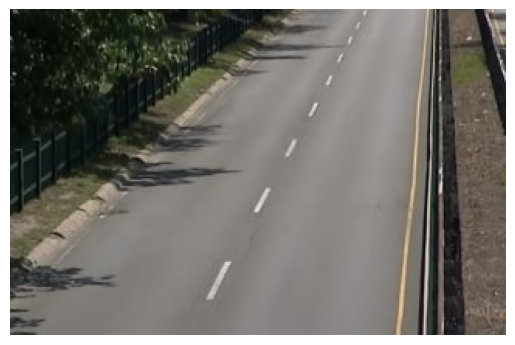

SSIM = 0.789794728088979
PSNR = 32.4059986564973


In [157]:
# Show frames

# Find SSIM between the original and the low-rank components
import skimage
from skimage.metrics import structural_similarity as ssim
print(frames[i].shape)
plt.imshow(L_frame[ 30:, :, ::-1, i].astype(np.uint8))
# remove the axis
plt.axis('off')
plt.show()

ssim_val = ssim(frames[i][ 30:, :, ::-1].astype(np.uint8), L_frame[ 30:, :, ::-1, i].astype(np.uint8), multichannel=True, channel_axis=2)
print(f"SSIM = {ssim_val}")

# Get PSNR
def psnr(img1, img2):
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20*np.log10(PIXEL_MAX / np.sqrt(mse))

psnr_val = psnr(frames[i][ 30:, :, ::-1].astype(np.uint8), L_frame[ 30:, :, ::-1, i].astype(np.uint8))
print(f"PSNR = {psnr_val}")